# 6.4.2 [실습] Word2Vec

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 획득

In [2]:
corpus = [
    "king is a strong man",
    "queen is a wise woman",
    "boy is a young man",
    "girl is a young woman",
    "prince is a young king",
    "princess is a young queen",
    "man is strong",
    "woman is pretty",
    "prince is a boy will be king",
    "princess is a girl will be queen",
]

## 불용어 제거하기

In [ ]:
def remove_stop_words(corpus):
    stop_words = ["is", "a", "will", "be"]
    results = []

    for text in corpus:
        tmp = text.split(" ")
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))

    return results


corpus = remove_stop_words(corpus)

In [4]:
for text in corpus:
    print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [5]:
words = []
for text in corpus:
    for word in text.split(" "):
        words.append(word)

words = set(words)

words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

## 단어별 인덱스 매핑 테이블 만들기

In [6]:
word2int = {}
for i, word in enumerate(words):
    word2int[word] = i

In [7]:
word2int

{'girl': 0,
 'king': 1,
 'queen': 2,
 'man': 3,
 'wise': 4,
 'pretty': 5,
 'boy': 6,
 'prince': 7,
 'princess': 8,
 'young': 9,
 'strong': 10,
 'woman': 11}

## 레이블 생성

In [8]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []

for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[
            max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1
        ]:
            if neighbor != word:
                data.append([word, neighbor])

In [9]:
df = pd.DataFrame(data, columns=["input", "label"])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


## 텐서플로로 word2vec 모델 구현하기

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

ONE_HOT_DIM = len(words)


def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding


X = []
Y = []

for x, y in zip(df["input"], df["label"]):
    X.append(to_one_hot_encoding(word2int[x]))
    Y.append(to_one_hot_encoding(word2int[y]))

X_train = np.asarray(X)
Y_train = np.asarray(Y)

encoding_dim = 2

input_word = Input(shape=(ONE_HOT_DIM,))
encoded = Dense(encoding_dim, use_bias=False)(input_word)
decoded = Dense(ONE_HOT_DIM, activation="softmax")(encoded)

w2v_model = Model(input_word, decoded)

w2v_model.compile(optimizer="adam", loss="categorical_crossentropy")

## 학습하기

In [11]:
w2v_model.fit(X_train, Y_train, epochs=1000, shuffle=True, verbose=0)

## word2vec 추출

In [12]:
vectors = w2v_model.layers[1].weights[0].numpy().tolist()

## word2vec의 좌푯값

In [14]:
w2v_df = pd.DataFrame(vectors, columns=["x1", "x2"])
w2v_df["word"] = list(words)
w2v_df = w2v_df[["word", "x1", "x2"]]
w2v_df

,word,x1,x2
0,girl,0.622303,-1.068473
1,king,-0.754331,0.904091
2,queen,1.299676,-0.842682
3,man,-0.170814,0.999977
4,wise,-0.072416,-1.600705
5,pretty,0.953229,-1.767871
6,boy,-0.495595,1.018929
7,prince,1.435318,1.357277
8,princess,-0.823315,-1.072921
9,young,-0.028253,-0.089252


## word2vec을 2차원 공간에 시각화

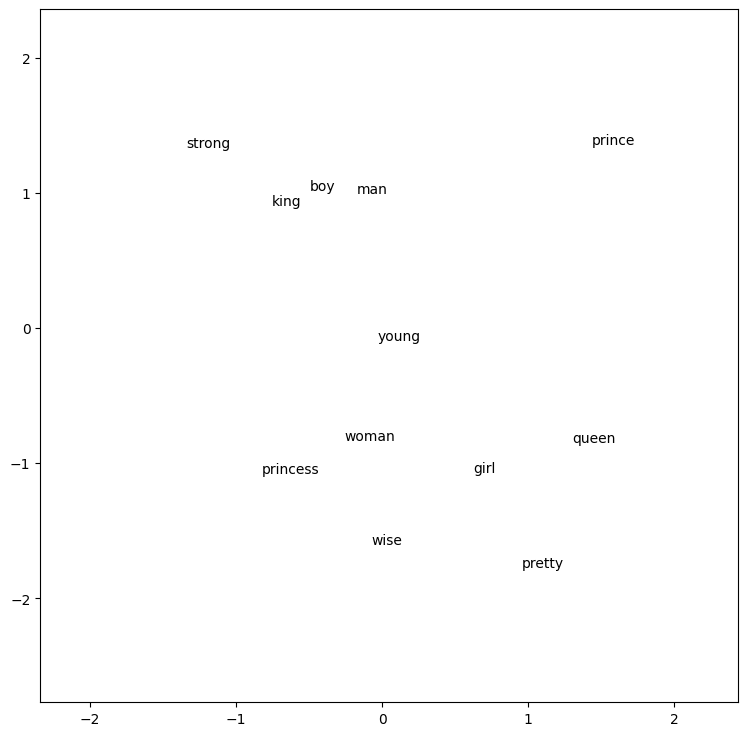

In [17]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df["word"], w2v_df["x1"], w2v_df["x2"]):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (9, 9)

plt.show()